In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 99.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.2 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [9]:
#getting the data
path = Path('persons')
categ = ['messi','ronaldo']


In [10]:

if not path.exists():
  path.mkdir()
  for player in categ:
    dest = path/player
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{player} pics')
    download_images(dest,urls=results)


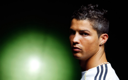

In [21]:
images = get_image_files(path)
im = Image.open(images[0])
im.to_thumb(128)

In [22]:
failed = verify_images(images)
failed

(#0) []

In [19]:
failed.map(Path.unlink)

(#9) [None,None,None,None,None,None,None,None,None]

In [27]:
pathtest = Path('persons/ronaldo')
pngims = pathtest.ls(file_exts='.png')

for file in pngims:

  file.unlink()

In [28]:
#categories
persons = ['messi','ronaldo']

#dataloaders and datablock
men = DataBlock(
    blocks = (ImageBlock,CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2,seed=42),
    get_y = parent_label,
    item_tfms = Resize(128)

)

In [29]:
#dataloader
men = men.new(
    item_tfms = RandomResizedCrop(224,min_scale=0.3),
    batch_tfms = aug_transforms()
)
dls = men.dataloaders(path)


In [32]:
learn = cnn_learner(dls,resnet18,metrics=accuracy)
learn.fine_tune(8)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,1.379548,0.786707,0.723077,00:21


epoch,train_loss,valid_loss,accuracy,time
0,0.809829,0.805789,0.707692,00:20
1,0.629240,0.549063,0.753846,00:21
2,0.528675,0.421404,0.800000,00:20
3,0.462482,0.332288,0.907692,00:20
4,0.395870,0.333478,0.907692,00:22
5,0.343957,0.304605,0.892308,00:22
6,0.323466,0.277989,0.907692,00:20
7,0.298714,0.275127,0.923077,00:20


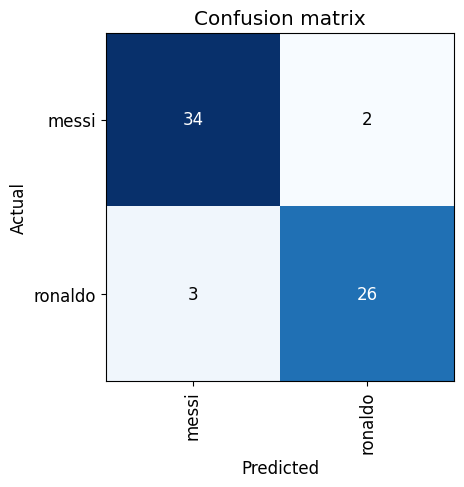

In [33]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

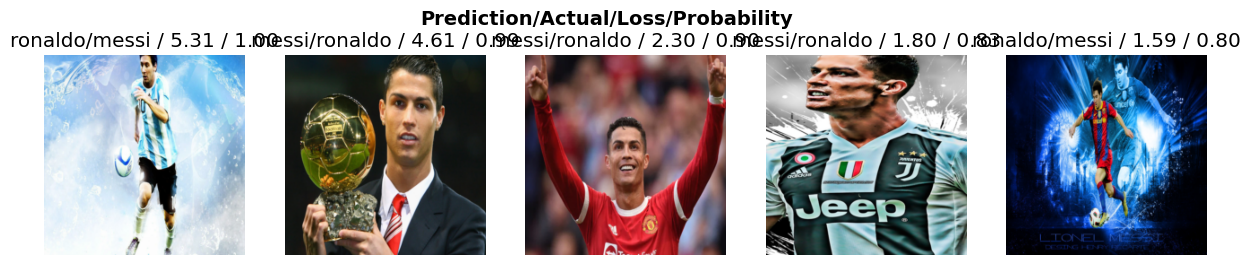

In [34]:
interp.plot_top_losses(5,nrows=1)

In [35]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [36]:
def image_classify(img):
  pred,pred_idx,probs = learn.predict(img)
  return dict(zip(persons,map(float,probs)))


In [37]:
image_classify('m3.jpeg')

{'messi': 0.9999563694000244, 'ronaldo': 4.363152038422413e-05}

In [38]:
#exporting model and bring it to deployment
learn.export('model.pkl')

In [39]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('model.pkl')]

In [40]:
learn_inf = load_learner(path/'model.pkl')


In [41]:
def image_classifyex(img):
  pred,pred_idx,probs = learn_inf.predict(img)
  return dict(zip(persons,map(float,probs)))


In [42]:
image_classifyex('m2.jpeg')

{'messi': 0.9680050611495972, 'ronaldo': 0.03199490159749985}

In [43]:
!pip install gradio
import gradio as gr

image = gr.inputs.Image(shape=(192,192))
label = gr.outputs.Label()
examples = ['m2.jpeg','m3.jpeg']
intf = gr.Interface(fn = image_classifyex, inputs = image,outputs = label,examples=examples)
intf.launch(inline=False,share=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.8/288.8 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 7.0 MB/s eta 0:00:00
   

<ipython-input-43-0fb5157b9c86>:4: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image = gr.inputs.Image(shape=(192,192))
<ipython-input-43-0fb5157b9c86>:4: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image = gr.inputs.Image(shape=(192,192))
<ipython-input-43-0fb5157b9c86>:5: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label()
<ipython-input-43-0fb5157b9c86>:5: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gr.outputs.Label()


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://581232d97a96e48c5e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
